# Initial Setting

In [66]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
import numpy as np
import numpy.random as random 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(1)
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.cuda.current_device())

cuda
True
1.6.0+cu101
0


# Model Definition

In [49]:
class Encoder(nn.Module):
    def __init__(self, n_features, emb_dim):
        super(Encoder, self).__init__()
        
        self.Linear1 = nn.Linear(n_features, 10)
        self.Linear2 = nn.Linear(10, emb_dim)
        
    def forward(self, x):
        x = self.Linear1(x)
        x = F.sigmoid(x)
        x = self.Linear2(x)
        return F.sigmoid(x)
    
class Decoder(nn.Module):
    def __init__(self, n_features, emb_dim):
        super(Decoder, self).__init__()
        
        self.Linear1 = nn.Linear(emb_dim, 8)
        self.Linear2 = nn.Linear(8, n_features)
        
    def forward(self, x):
        x = self.Linear1(x)
        x = F.sigmoid(x)
        x = self.Linear2(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, n_features, emb_dim=5):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(n_features, emb_dim).to(device)
        self.decoder = Decoder(n_features, emb_dim).to(device)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [50]:
model = Autoencoder(17,emb_dim=3)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Data Sets

## Lorentz Equation

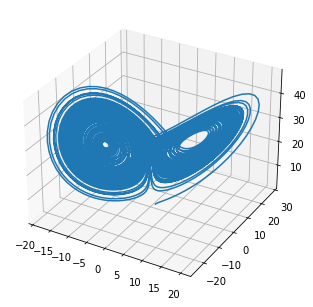

In [51]:
dt=0.01
dur=120
time_step=dur/dt
p=10
r=28
b=8/3

def x_dot(x, y, p=p):
    return p * (y - x)

def y_dot(x, y, z, r=r):
    return x * (r - z) - y

def z_dot(x, y, z, b=b):
    return x * y - b * z

def lorentz(X):
    x = X[0]
    y = X[1]
    z = X[2]
    X_dot = np.array([x_dot(x, y), y_dot(x, y, z), z_dot(x, y, z)])
    return X_dot

def RungeKutta(X, dt=dt):
    k1 = lorentz(X)
    k2 = lorentz(X + k1*dt/2)
    k3 = lorentz(X + k2*dt/2)
    k4 = lorentz(X + k3*dt/2)
    X_next = X + dt/6*(k1 + 2*k2 + 2*k3 + k4)
    return X_next
    

def X_new(X):
    x = X[0]
    y = X[1]
    z = X[2]
    Xvec_new = [x + dt * x_dot(x, y),
                y + dt * y_dot(x, y, z),
                z + dt * z_dot(x, y, z)]
    
    return Xvec_new

X_init=np.array([1, 1, 1])
X_seq = [X_init]
for i in range(int(time_step)):
    X_seq.append(RungeKutta(X_seq[-1]))

X_seq = np.array(X_seq).T

fig = plt.figure()
ax = Axes3D(fig)
ax.plot(X_seq[0,:], X_seq[1,:], X_seq[2,:])
plt.show()

In [52]:
z_reversed=X_seq[2,10000:]
z_reversed=z_reversed[::-1]
X_seq[2,10000:]=z_reversed 

In [53]:
# Generate 17 dim time-series data
np.random.seed(seed=32)
W = (random.rand(17,3) - 0.5) * 10
X_ex = np.dot(W,X_seq)

# Data Loader

Lorentz+Normalization

In [54]:
scaler = preprocessing.StandardScaler()
X_ex = scaler.fit_transform(X_ex)

Lorentz_train = torch.tensor(X_ex[:,:8000]).float()
Lorentz_test= torch.tensor(X_ex[:,8000:]).float()
Lorentz_train.shape

torch.Size([17, 8000])

In [55]:
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, timeseries, transform=None):#timeseries = variables * time
        self.transform = transform
        self.data_num = timeseries.shape[1]
        self.data = []
        self.label = 0
        for i in range(timeseries.shape[1]):
            self.data.append(timeseries[:, i])
            
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label
        
        return out_data, out_label

In [56]:
train_data = MyDataset(Lorentz_train)
test_data = MyDataset(Lorentz_test)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)


# Train Function

In [58]:
def train(model, train_loader, criterion, optimizer, n_epochs=100):
    losses = []
    model.to(device)
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0      

        for data in train_loader:
            optimizer.zero_grad()
            z, _ = data
            z_cuda = z.to(device)
            preds = model(z_cuda)
            loss = criterion(preds, z_cuda)
            loss.backward()
            optimizer.step()
            running_loss += loss.data
          
        
        ave_loss = running_loss / len(train_data)
        losses.append(ave_loss)
        if epoch%10==0:
            print(f'epoch:{epoch:3} loss: {ave_loss:10.8f}')

    plt.plot(losses)
    return losses

# Train

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:  0 loss: 0.00790020
epoch: 10 loss: 0.00162351
epoch: 20 loss: 0.00144114
epoch: 30 loss: 0.00046444
epoch: 40 loss: 0.00017944
epoch: 50 loss: 0.00013874
epoch: 60 loss: 0.00012675
epoch: 70 loss: 0.00011969
epoch: 80 loss: 0.00011386
epoch: 90 loss: 0.00010836
epoch:100 loss: 0.00010287
epoch:110 loss: 0.00009738
epoch:120 loss: 0.00009210
epoch:130 loss: 0.00008720
epoch:140 loss: 0.00008180
epoch:150 loss: 0.00007219
epoch:160 loss: 0.00002838
epoch:170 loss: 0.00001669
epoch:180 loss: 0.00001291
epoch:190 loss: 0.00001070


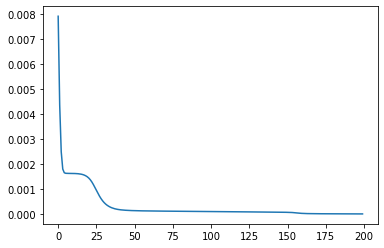

In [59]:
with torch.autograd.set_detect_anomaly(True):
    losses = train(model, train_loader, loss_function, optimizer, n_epochs=200)

In [60]:
model_path = 'ae_model8_3_loader.pth'
torch.save(model.to('cpu').state_dict(), model_path)

# Test

In [98]:
def test(model, criterion, test_data, t=None):
    model.to(device)
    model.eval()
    reconstruct_error = []
    reconstruct = []

    with torch.no_grad():
        for i in range(test_data.shape[1]):
            z = test_data[:,i].to(device)
            pred = model(z)
            loss = criterion(pred, z)
            reconstruct_error.append(loss)
            reconstruct.append(pred.cpu().numpy())
    return reconstruct_error, np.array(reconstruct)

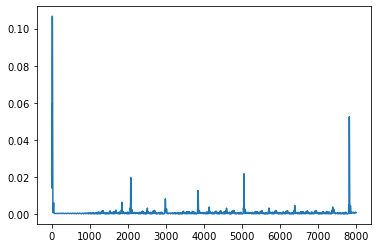

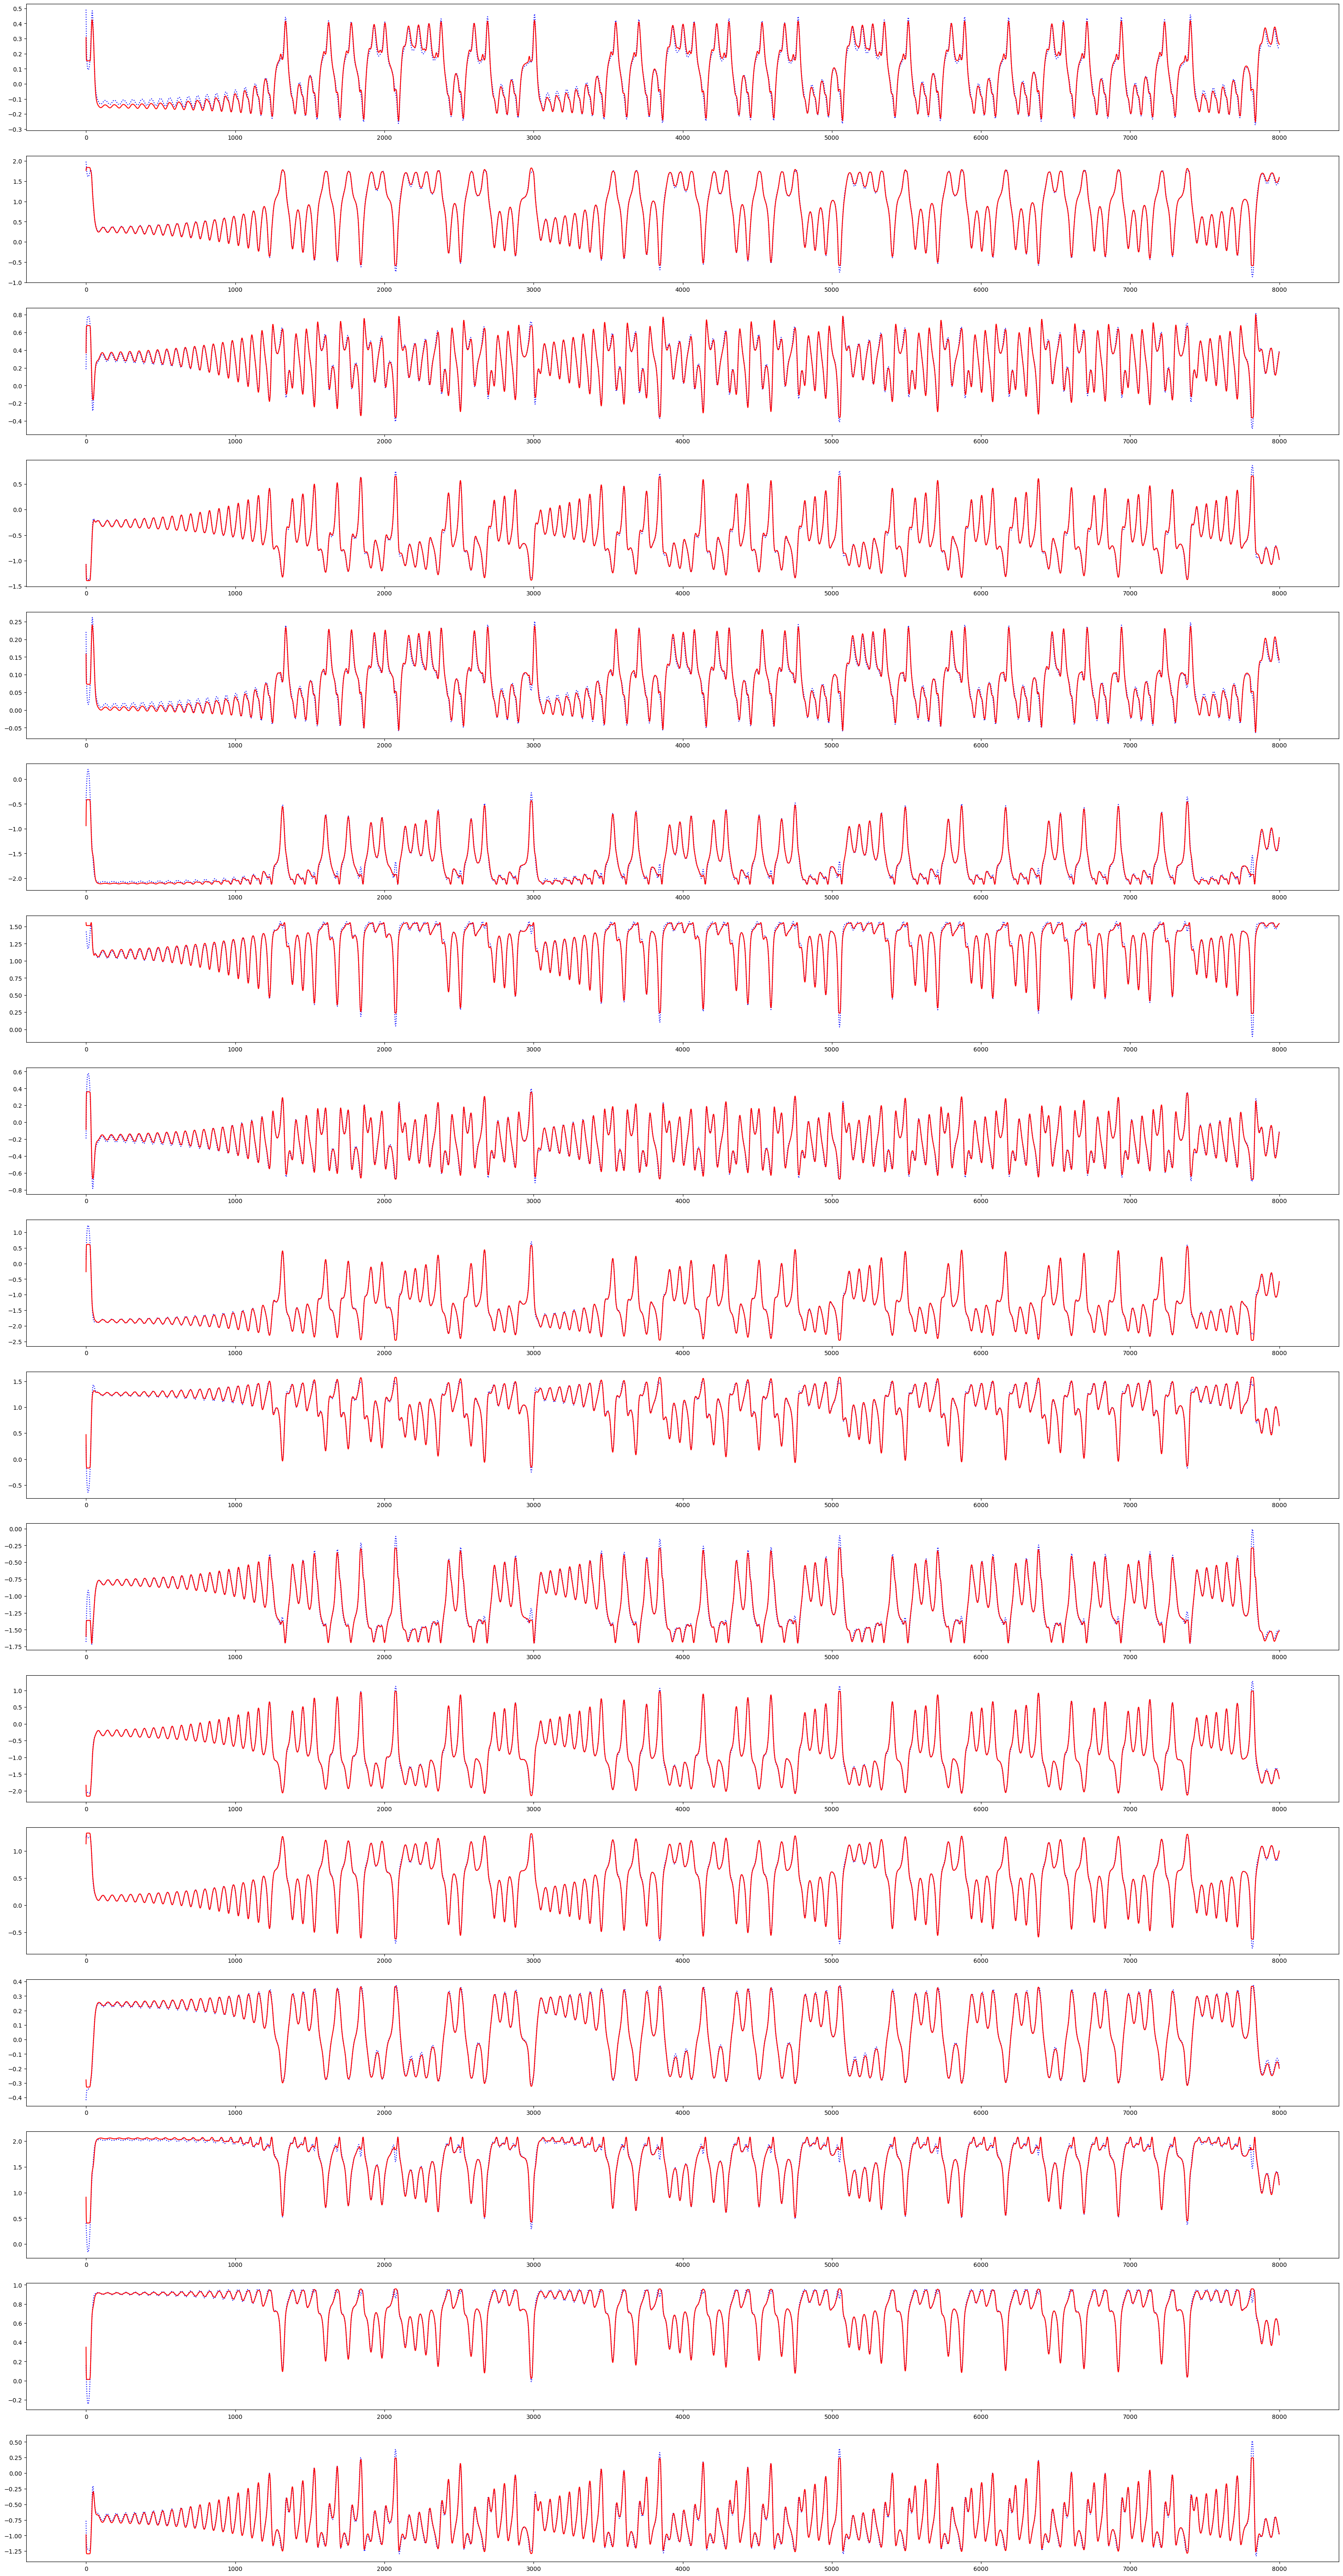

In [99]:
reconstruct_error_train, reconstruct_train = test(model, loss_function, Lorentz_train)

plt.plot(reconstruct_error_train)

reconstruct_train = reconstruct_train.T
fig = plt.figure(figsize=(40,80),dpi=100)
i=1
for i in range(len(Lorentz_train)):
    l = len(Lorentz_train)
    ax=fig.add_subplot(l,1,i+1)
    ax.plot(Lorentz_train[i,:], color='b', linestyle='dotted')
    ax.plot(reconstruct_train[i,:], color='r')

plt.show()
# Reconstruction on Train Data

# Test Set

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


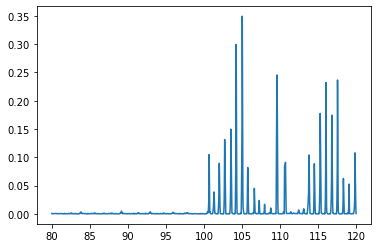

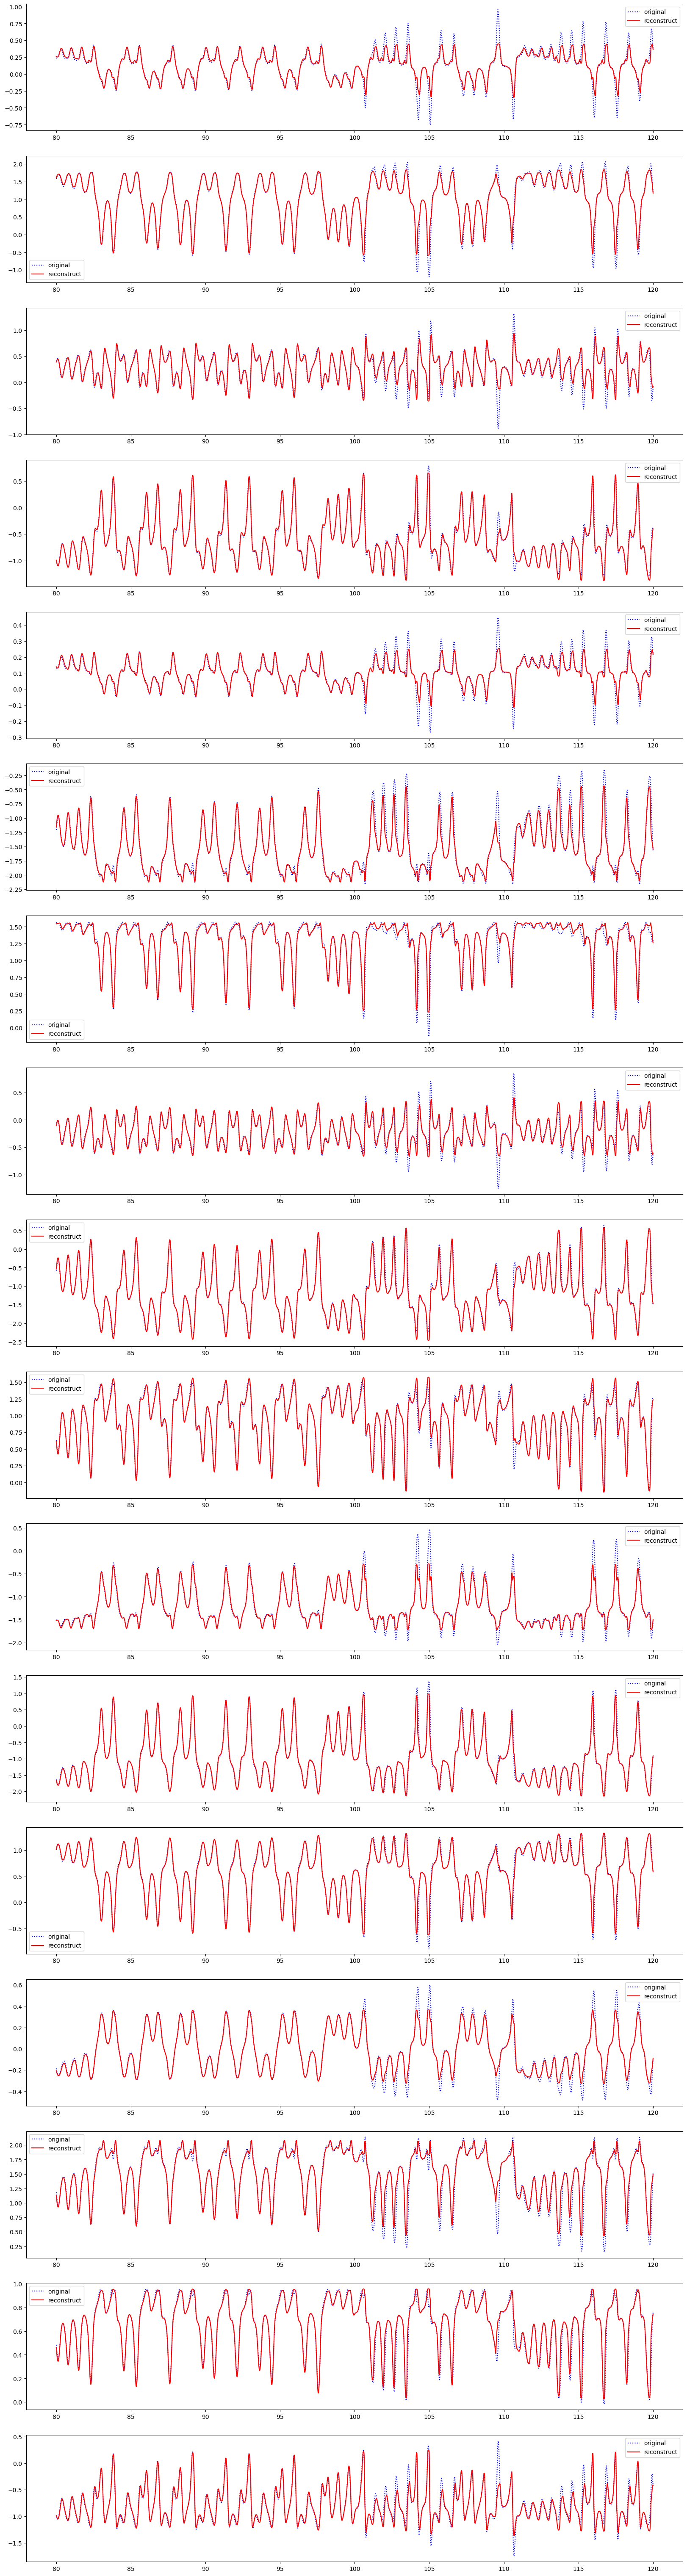

In [110]:
test_t=np.linspace(80,120,4001)
reconstruct_error_test, reconstruct_test = test(model, loss_function, Lorentz_test, t=test_t)

plt.plot(test_t, reconstruct_error_test)

reconstruct_test = reconstruct_test.T
fig = plt.figure(figsize=(20,80),dpi=100)
i=1

for i in range(len(Lorentz_test)):
    l = len(Lorentz_test)
    ax=fig.add_subplot(l,1,i+1)
    ax.plot(test_t, Lorentz_test[i,:], color='b', linestyle='dotted', label='original')
    ax.plot(test_t, reconstruct_test[i,:], color='r', label='reconstruct')
    ax.legend()

plt.show()

# Reconstruct Error Moving Average

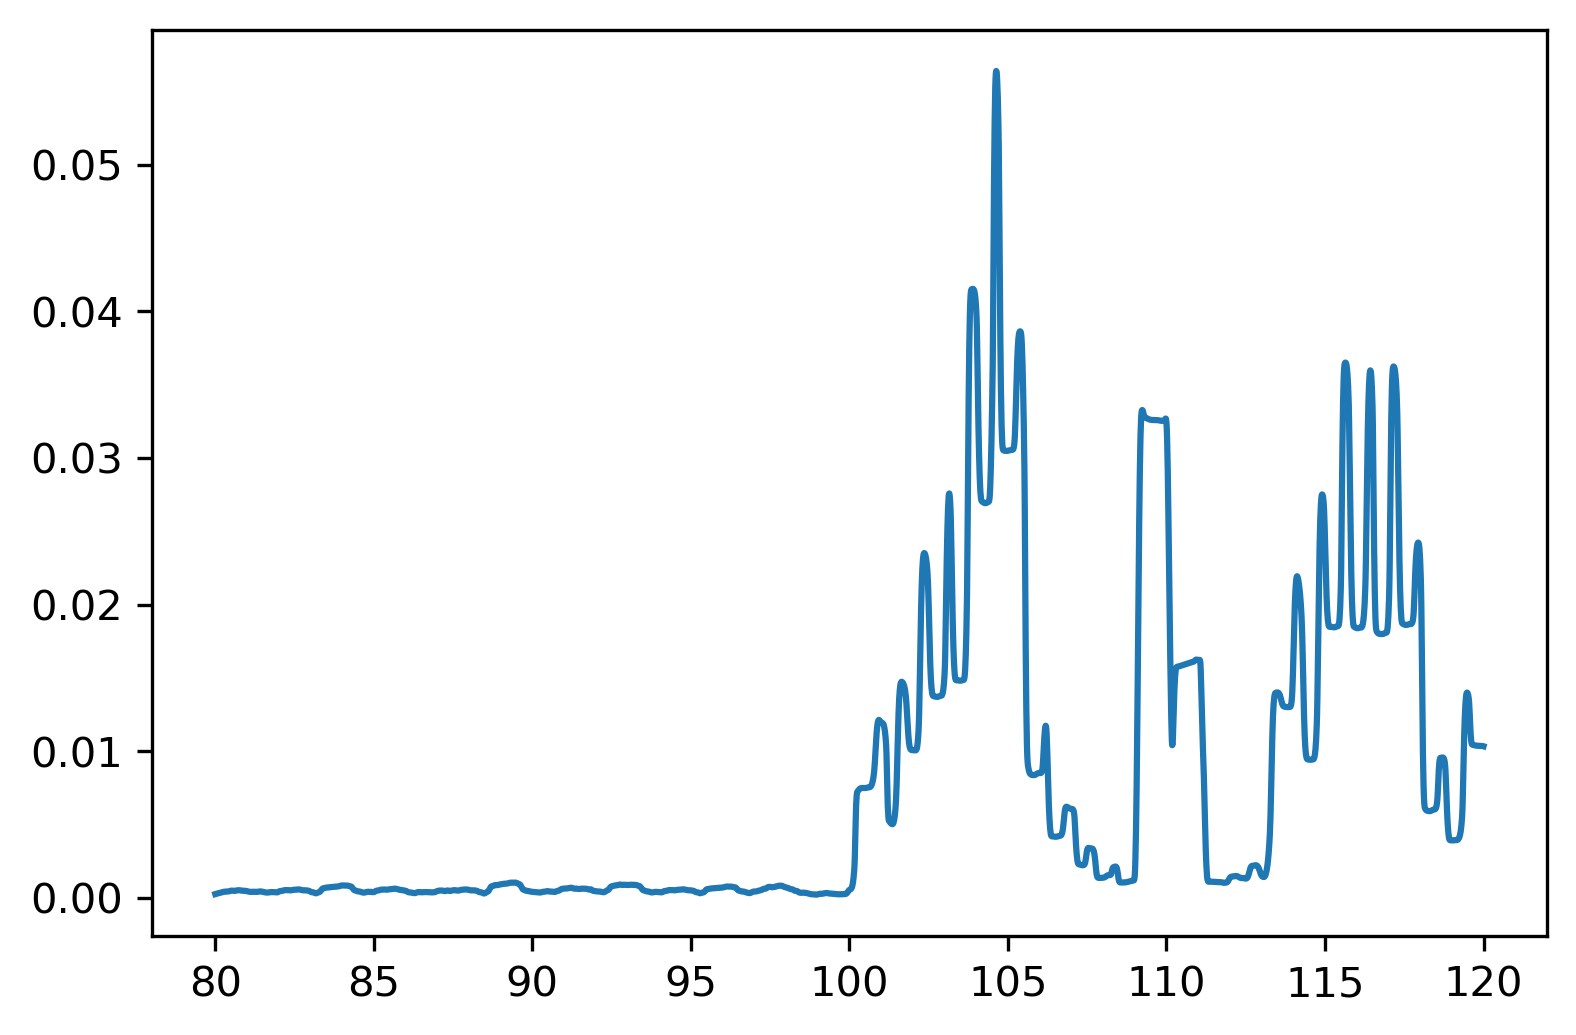

In [111]:
b = np.ones(100)/100
re_mv = np.convolve(reconstruct_error_test, b, mode='same')
fig = plt.figure(dpi=300)
plt.plot(test_t ,re_mv)

In [115]:
import matplotlib
matplotlib.colors.cnames

{'aliceblue': '#F0F8FF',
 'antiquewhite': '#FAEBD7',
 'aqua': '#00FFFF',
 'aquamarine': '#7FFFD4',
 'azure': '#F0FFFF',
 'beige': '#F5F5DC',
 'bisque': '#FFE4C4',
 'black': '#000000',
 'blanchedalmond': '#FFEBCD',
 'blue': '#0000FF',
 'blueviolet': '#8A2BE2',
 'brown': '#A52A2A',
 'burlywood': '#DEB887',
 'cadetblue': '#5F9EA0',
 'chartreuse': '#7FFF00',
 'chocolate': '#D2691E',
 'coral': '#FF7F50',
 'cornflowerblue': '#6495ED',
 'cornsilk': '#FFF8DC',
 'crimson': '#DC143C',
 'cyan': '#00FFFF',
 'darkblue': '#00008B',
 'darkcyan': '#008B8B',
 'darkgoldenrod': '#B8860B',
 'darkgray': '#A9A9A9',
 'darkgreen': '#006400',
 'darkgrey': '#A9A9A9',
 'darkkhaki': '#BDB76B',
 'darkmagenta': '#8B008B',
 'darkolivegreen': '#556B2F',
 'darkorange': '#FF8C00',
 'darkorchid': '#9932CC',
 'darkred': '#8B0000',
 'darksalmon': '#E9967A',
 'darkseagreen': '#8FBC8F',
 'darkslateblue': '#483D8B',
 'darkslategray': '#2F4F4F',
 'darkslategrey': '#2F4F4F',
 'darkturquoise': '#00CED1',
 'darkviolet': '#9400D3